In [1]:
#!pip install nltk
#!pip install pandas
#!pip install -U matplotlib
#!pip install numpy
#!pip install -U scikit-learn
#!pip install tensorflow   # installed version 2.2.0 (along with python 3.8.2) on machine
###!pip install --upgrade tensorflow
#!pip install seaborn
#!pip install wordcloud
#!pip install --upgrade gensim
##!pip install -U textblob
#!pip install keras
#!pip install spacytextblob






In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import gensim
from textblob import TextBlob
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import tensorflow 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras import callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras import metrics


from wordcloud import WordCloud
import seaborn as sns
import pprint
import matplotlib.pyplot as plt; plt.rcdefaults()


In [3]:

dataset = pd.read_csv('Datasets/SemEval2017-task4-dev.subtask-A.english.INPUT.txt', 
                       sep='\t',header=None)

dataset.columns = ['id','sentiment','tweet','unknown']  
dataset = dataset.drop(['unknown'], axis=1) 
dataset = dataset.drop(['id'], axis=1) # dropped id # needed for full input dataset
dataset.dropna() # drop rows with missing values (inplace=True parameter removed for now)



print("First 5 rows of dataset")
print(dataset.head(5))
len(dataset)

First 5 rows of dataset
  sentiment                                              tweet
0   neutral  Picturehouse's, Pink Floyd's, 'Roger Waters: T...
1   neutral  Order Go Set a Watchman in store or through ou...
2  negative  If these runway renovations at the airport pre...
3   neutral  If you could ask an onstage interview question...
4  positive  A portion of book sales from our Harper Lee/Go...


20632

neutral     10342
positive     7059
negative     3231
Name: sentiment, dtype: int64


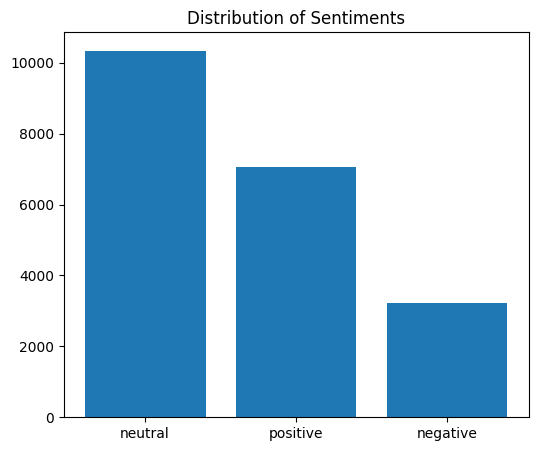

In [4]:
distribution = dataset.sentiment.value_counts() # value_counts() is a pandas function
plt.figure(figsize=(6,5))
plt.bar(distribution.index, distribution.values)
plt.title("Distribution of Sentiments")

print(distribution)

In [5]:
#Encode labels neutral=1, negative=0, positive=2
label=LabelEncoder()
dataset['sentiment'] = label.fit_transform(dataset['sentiment'])

# check the updated labels
print("Encoded labels: neutral=1, negative=0, positive=2")
print(dataset.head(5))


Encoded labels: neutral=1, negative=0, positive=2
   sentiment                                              tweet
0          1  Picturehouse's, Pink Floyd's, 'Roger Waters: T...
1          1  Order Go Set a Watchman in store or through ou...
2          0  If these runway renovations at the airport pre...
3          1  If you could ask an onstage interview question...
4          2  A portion of book sales from our Harper Lee/Go...


####**Pre-process the Data** 


Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

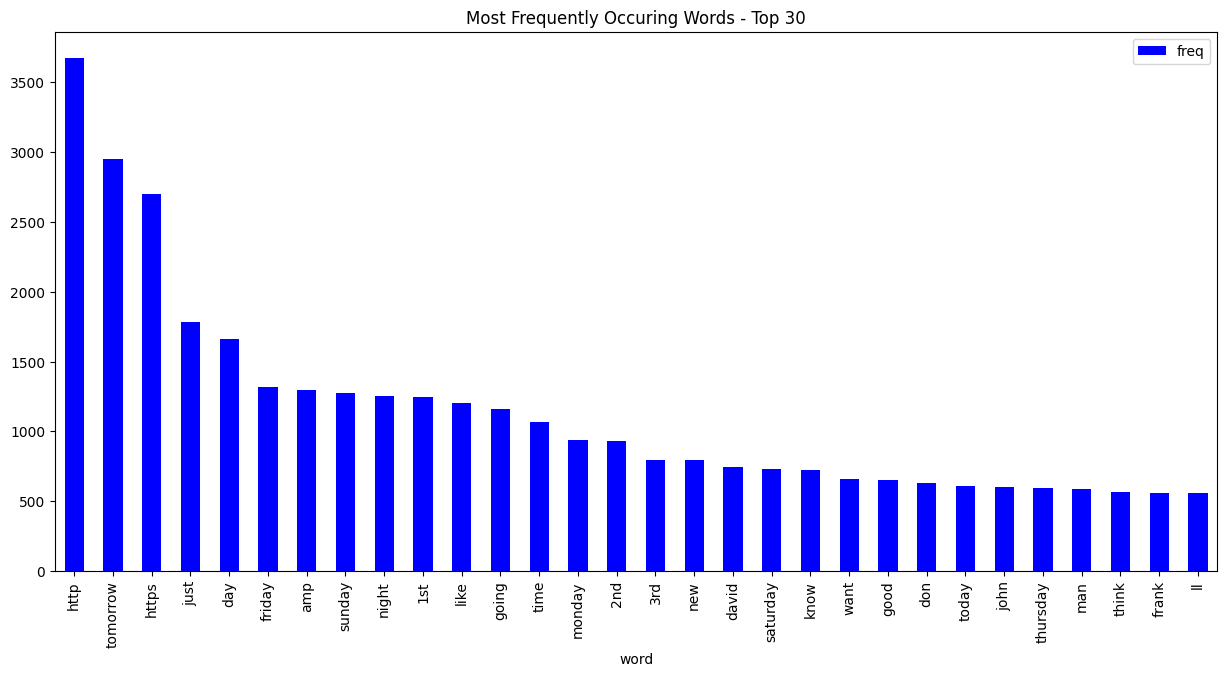

In [6]:
# Find stopwords 

def find_stopwords(text):
  text = text
  vectorizer = CountVectorizer(stop_words = 'english') #
  words = vectorizer.fit_transform(text) 
  sum_words = words.sum(axis=0)
  word_freq = [(word, sum_words[0, i]) for word, i in vectorizer.vocabulary_.items()]
  word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)
  frequency = pd.DataFrame(word_freq, columns=['word', 'freq']) 

  return frequency, word_freq

frequency, word_freq = find_stopwords(dataset.tweet)
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")


In [7]:
# Convert to lowercase, remove punctuation, noise, such as non-alphanumeric characters, 
# urls, and double white spaces. Remove stopwords

# Downloads needed when running script on browser
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger') 
nltk.download('wordnet')

def preprocess(tweet): 
    
    tweet = re.sub(r"[Ww]on't","willn't", str(tweet))# 1st step to expand "won't"
    tweet = re.sub(r"n't",' not', str(tweet)) # expand negative contractions (which will expand 'won't')
    tweet = re.sub(r"'ve",' have', str(tweet)) # expand "have" contractions
    tweet = re.sub(r"'s",'s' , str(tweet)) # remove apotrophe in possessives, but keep 's'
    tweet = re.sub(r"(@\S+|#\S+)",' ',str(tweet)) #remove hashtags and users: @ and #
    tweet = re.sub(r"\s\s+",' ',str(tweet)) # replace more than two spaces with one
    tweet = re.sub(r"([^a-zA-z0-9]+|https?:\S+)",' ',str(tweet).lower()).strip() #remove urls
    
    sent = TextBlob(tweet) # lemmatize text
    tag_dict = {"JJ": 'a', 
                "NN": 'n', 
                "V":  'v', 
                "R":  'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'a')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    tweet =  " ".join(lemmatized_list)
    tweet = remove_stopwords(tweet) # remove stopwords (best done after lemmatizing)
       
    return tweet

# Use lambda to run preprocess function on each row of the dataset tweets
dataset.tweet = dataset.tweet.apply(lambda x: preprocess(x))



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
print('Tweets after preprocessing')
print(dataset['tweet'].head())

Tweets after preprocessing
0    picturehouses pink floyds roger water walll op...
1    order set watchman store website tuesday half ...
2    runway renovations airport prevent taylor swif...
3     ask onstage interview question miss usa tomorrow
4    portion book sales harper lee set watchman rel...
Name: tweet, dtype: object


Top 30 words after stopword removal in preprocessing


Text(0.5, 1.0, 'Top 30 Words After Stopword Removal')

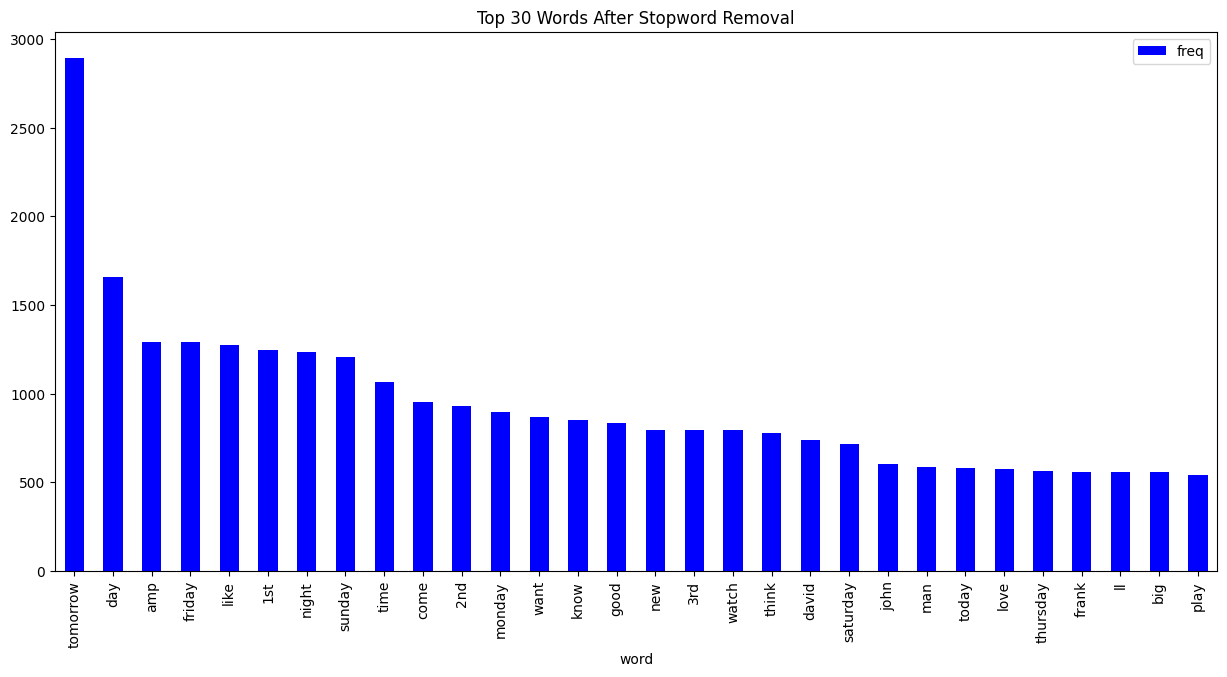

In [9]:
print('Top 30 words after stopword removal in preprocessing')

frequency, word_freq = find_stopwords(dataset.tweet)
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Top 30 Words After Stopword Removal")

In [10]:
#explore lengths of tweets and plot them by length

tweet_lengths = []
for index, row in dataset.iterrows():
    tweet_lengths.append(len(row['tweet']))



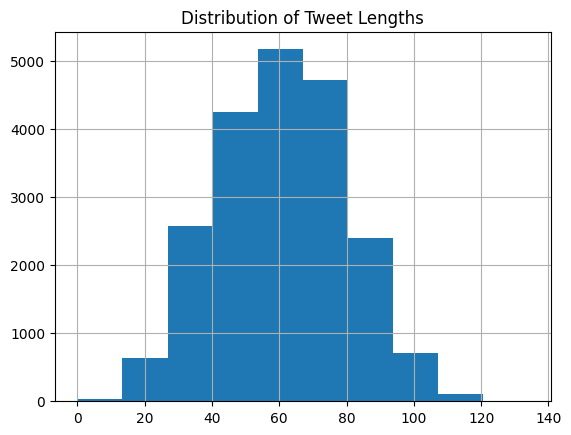

count    20632.000000
mean        60.593156
std         19.007504
min          0.000000
25%         47.000000
50%         61.000000
75%         74.000000
max        134.000000
dtype: float64

In [11]:
#rev_len = [len(i) for i in X_train]
pd.Series(tweet_lengths).hist()
plt.title('Distribution of Tweet Lengths')
plt.show()
pd.Series(tweet_lengths).describe()


Text(0.5, 1.0, 'Vocabulary from Tweets')

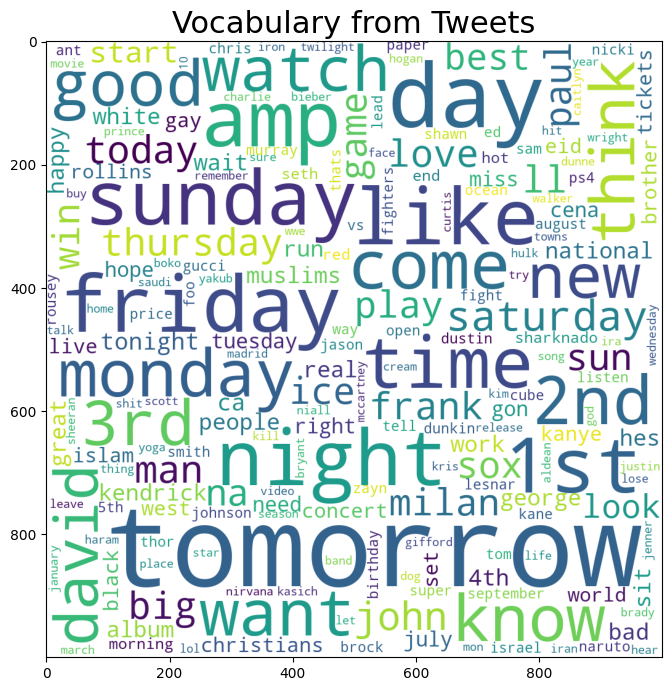

In [12]:

wordcloud = WordCloud(background_color = 'white', width = 1000, 
                      height = 1000).generate_from_frequencies(dict(word_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("Vocabulary from Tweets", fontsize = 22)

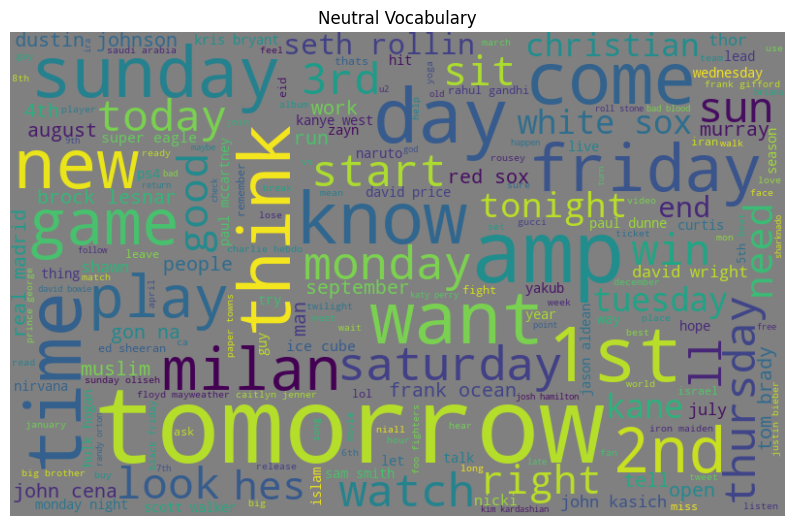

In [13]:
neutral_vocab =' '.join([text for text in dataset['tweet'][dataset['sentiment'] == 1]])

wordcloud = WordCloud(background_color = 'grey', width=800, height=500, 
                      random_state = 0, max_font_size = 110).generate(neutral_vocab)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Neutral Vocabulary')
plt.show()

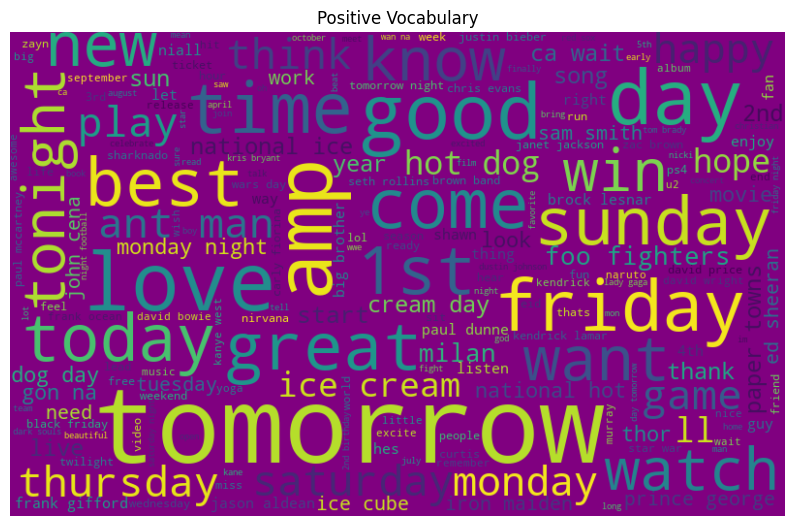

In [14]:
positive_vocab =' '.join([text for text in dataset['tweet'][dataset['sentiment'] == 2]])

wordcloud = WordCloud(background_color = 'purple', width=800, height=500, 
                      random_state = 0, max_font_size = 110).generate(positive_vocab)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Positive Vocabulary')
plt.show()

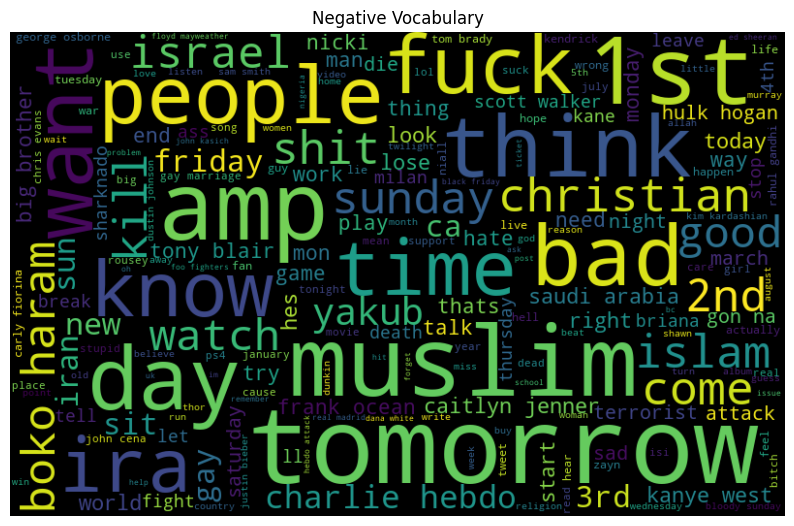

In [15]:
negative_vocab =' '.join([text for text in dataset['tweet'][dataset['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 1, 
                      max_font_size = 110).generate(negative_vocab)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Negative Vocabulary')
plt.show()

##Create Word Index and Embeddings


In [16]:


def build_word_index(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    word_index = tokenizer.word_index # dictionary mapping each word to an integer
    
    return word_index
    

word_to_int= build_word_index(dataset.tweet)

    

In [17]:
def build_embeddings(word_dict):
    embeddings_dict = {}
    # Open the glove embeddings text file
    file = open('Datasets/glove.6B.300d.txt')
    for line in file:
        # Read in each line, split words add to a list
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32') #convert glove values into array
        embeddings_dict[word] = vector # assign words and their values to dict
    file.close()
    print('Found %s word vectors.' %len(embeddings_dict))
    
    vocab_size = len(word_dict) + 1
    # creating a matrix with zeroes of shape vocab x embedding dimension
    embedding_matrix = np.zeros((vocab_size, 300)) #each embedding vector is of length 300
    # Iterate through word, index in the dictionary
    for word, i in word_dict.items():
       # use word from word_dict to search for its corresponding vector in embeddings
        embedding_vector = embeddings_dict.get(word) 
        if embedding_vector is not None and len(embedding_vector)==300:
            # Storing it in a matrix
            embedding_matrix[i] = embedding_vector # store word index and its word vector
    return embedding_matrix,embeddings_dict,vocab_size

embeddings,embeddings_dict,vocab_size = build_embeddings(word_to_int)

#Check that mappings look right
#print('embedding_matrix for int 7, which corresponds to "friday"',embeddings[7])
#print('embedding_dict vector for "friday"',embeddings_dict['friday'])

#Verify that the vectors for integer 7 are equal to those for 'Friday'
#if list(embeddings[7]) == list(embeddings_dict['friday']):
#    print('True')




Found 382372 word vectors.


In [18]:
#build word dictionary based on word_index and 
#pass them into the padded sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset.tweet)
word_index = tokenizer.word_index

#print(word_index)
#print(word_to_int)



#### **Split data into training and testing**



In [19]:


# Splitting the data into training and testing sets
dataset = shuffle(dataset)
X = dataset.tweet
y = dataset.sentiment

# New split statements
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,shuffle=True, stratify=y_train)



#### **Split training and testing into input data (features) and target data (labels)**

In [20]:
# Create placeholders for padded sequences of chosen length 

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),maxlen = 60)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),maxlen = 60)
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val),maxlen = 60)


# convert target data into array
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_val = y_val.to_numpy()

# reshape from 1D to 2D
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

#General check for datatypes and shapes
print("y_train type",type(y_train))
print("y_test type",type(y_test))
print("y_val type",type(y_val))
print("X_train type",type(X_train))
print("X_train type",type(X_train))
print("X_val type",type(X_val))

print('X_train shape',X_train.shape)
print('y_train shape',y_train.shape)
print('X_test shape',X_test.shape)
print('y_test shape',y_test.shape)
print('X_val shape',X_val.shape)
print('y_val shape',y_val.shape)

print('X_train len',len(X_train))
print('y_train len',len(y_train.shape))
print('X_test len',len(X_test.shape))
print('y_test len',len(y_test.shape))
print('X_val len',len(X_val.shape))
print('y_val len',len(y_val.shape))



y_train type <class 'numpy.ndarray'>
y_test type <class 'numpy.ndarray'>
y_val type <class 'numpy.ndarray'>
X_train type <class 'numpy.ndarray'>
X_train type <class 'numpy.ndarray'>
X_val type <class 'numpy.ndarray'>
X_train shape (12378, 60)
y_train shape (12378, 1)
X_test shape (4127, 60)
y_test shape (4127, 1)
X_val shape (4127, 60)
y_val shape (4127, 1)
X_train len 12378
y_train len 2
X_test len 2
y_test len 2
X_val len 2
y_val len 2


####**Define the model** 

In [21]:


model = Sequential()
model.add(layers.Embedding(vocab_size,300,weights=[embeddings], input_length = 60))


model.add(SpatialDropout1D(0.4)) 
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))) 
model.add(Dense(3,activation='softmax')) # 3 classes will be output
opt = Adam(learning_rate=0.01)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 300)           6115500   
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 300)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 6,302,767
Trainable params: 6,302,767
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
reduce_lr = ReduceLROnPlateau(factor=0.01,min_lr = 0.0000001, monitor = 'val_loss',verbose = 1) #to reduce learning rate when a metric has stopped improving.
es = callbacks.EarlyStopping(monitor='loss', patience=1)

batch_size=60


#Training options with class weights (ideal for original input dataset)
class_weight = {0:3.,1: 1., 2: 2.} # 0=negative (lowest count), 1=neutral (highest count), 2=positive
model.fit(X_train, y_train, epochs = 10, batch_size=batch_size, 
          callbacks=[reduce_lr,es],class_weight=class_weight, 
          validation_data=(X_val, y_val),verbose=True) 



Epoch 1/10
207/207 [==============================] - 103s 472ms/step - loss: 1.4533 - accuracy: 0.5430 - val_loss: 0.8711 - val_accuracy: 0.5963 - lr: 0.0100
Epoch 2/10
207/207 [==============================] - 95s 461ms/step - loss: 1.0048 - accuracy: 0.7090 - val_loss: 0.8894 - val_accuracy: 0.6106 - lr: 0.0100
Epoch 3/10
207/207 [==============================] - 95s 457ms/step - loss: 0.6494 - accuracy: 0.8213 - val_loss: 1.1041 - val_accuracy: 0.6113 - lr: 0.0100
Epoch 4/10
207/207 [==============================] - 93s 451ms/step - loss: 0.4583 - accuracy: 0.8741 - val_loss: 1.2822 - val_accuracy: 0.5956 - lr: 0.0100
Epoch 5/10
207/207 [==============================] - 94s 452ms/step - loss: 0.3426 - accuracy: 0.9082 - val_loss: 1.5335 - val_accuracy: 0.5980 - lr: 0.0100
Epoch 6/10
207/207 [==============================] - 94s 455ms/step - loss: 0.2933 - accuracy: 0.9248 - val_loss: 1.7722 - val_accuracy: 0.5871 - lr: 0.0100
Epoch 7/10
207/207 [==============================]

In [23]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=10)
print("test loss, test acc:", results)

Evaluate on test data
413/413 [==============================] - 12s 30ms/step - loss: 2.2759 - accuracy: 0.5711
test loss, test acc: [2.275888442993164, 0.5711170434951782]


              precision    recall  f1-score   support

    negative       0.43      0.47      0.45       646
     neutral       0.63      0.57      0.60      2069
    positive       0.57      0.62      0.59      1412

    accuracy                           0.57      4127
   macro avg       0.54      0.55      0.55      4127
weighted avg       0.58      0.57      0.57      4127



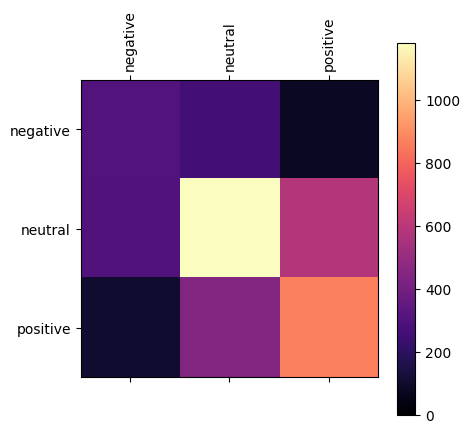

In [24]:

from sklearn.metrics import classification_report

labels = {'negative':0,'neutral':1, 'positive':2}

# Add test vector "X_test" with corresponding "y_test" to trained model "model"
y_predicted = tensorflow.argmax(model.predict(X_test), axis=1)

# Confusion matrix
cf = tensorflow.math.confusion_matrix(y_test, y_predicted)
plt.matshow(cf, cmap='magma')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels=labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels=labels)
plt.clim(0, None)

# Report
print(classification_report(y_test, y_predicted, target_names=labels, zero_division=1))